In [2]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from inspect import signature
from matplotlib import pyplot as plt
from dacbench.logger import Logger, log2dataframe, load_logs
import seaborn as sns
import glob
from plotting import _plot_performance_over_time, plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave
#from plotting import plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/envs/__init__.py:35: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/benchmarks/__init__.py:26: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028


DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


In [3]:
def toDataFrame(glob_path, col_name, col_index, method=None, dataset=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    df['epoch'] = df.index + 1
    df = df.melt(id_vars=['epoch'])
    df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        df['method'] = method

    if dataset:
        df['dataset'] = dataset

    return df

def toChunkedDataFrame(glob_path, col_name, col_index, chunk_size, method=None, dataset=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]

    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()

    result_df = pd.DataFrame()
    for col in df.columns:
        reshaped_data = df[col].values.reshape(-1, chunk_size)
        result_df[col] = reshaped_data.mean(axis=1)

    result_df.reset_index()

    result_df['epoch'] = result_df.index + 1
    result_df = result_df.melt(id_vars=['epoch'])
    result_df.rename(columns={'variable': 'seed'}, inplace=True)

    if method:
        result_df['method'] = method

    if dataset:
        result_df['dataset'] = dataset

    return result_df

def get_final_labels_and_stats(data, epoch_col="epoch", value_col="value", group_col="method",
                               label_format="{label} ({mean:.3f} SE {sem:.3f})"):
    """
    Computes final aggregated stats and creates new legend labels, preserving the original order.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the data with columns for epoch, value, and group identifier.
    epoch_col : str, default "epoch"
        Column name representing the epoch.
    value_col : str, default "value"
        Column name for the metric values.
    group_col : str, default "method"
        Column name used to group the data.
    label_format : str, default "{label}: {mean:.3f} ± {sem:.3f}"
        A format string used to create new legend labels, where {label} is the group,
        {mean} is the computed mean, and {sem} is the standard error.

    Returns:
    --------
    new_labels : list of str
        A list of updated legend labels with the final aggregated values in the original order.
    final_stats : pd.DataFrame
        A DataFrame indexed by the group column containing the mean and standard error,
        reindexed to preserve the original order of appearance.
    """
    # Determine the final epoch
    final_epoch = data[epoch_col].max()

    # Filter data to only include the final epoch
    final_data = data[data[epoch_col] == final_epoch]

    # Compute aggregated statistics (mean and standard error) grouped by the given group column
    final_stats = final_data.groupby(group_col)[value_col].agg(["mean", "sem"])

    # Get the original order of methods as they first appear in the data
    original_order = data[group_col].drop_duplicates().tolist()

    # Reindex final_stats to follow the original order (dropping any methods that might be missing)
    final_stats = final_stats.reindex(original_order)

    # Create new labels in the preserved order
    new_labels = []
    for label in original_order:
        if label in final_stats.index and pd.notnull(final_stats.loc[label, "mean"]):
            new_label = label_format.format(label=label,
                                            mean=final_stats.loc[label, "mean"],
                                            sem=final_stats.loc[label, "sem"])
        else:
            new_label = label
        new_labels.append(new_label)
    
    return new_labels


sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
palette = sns.color_palette([palette[0], palette[4], palette[2], palette[5]])
# sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.15)

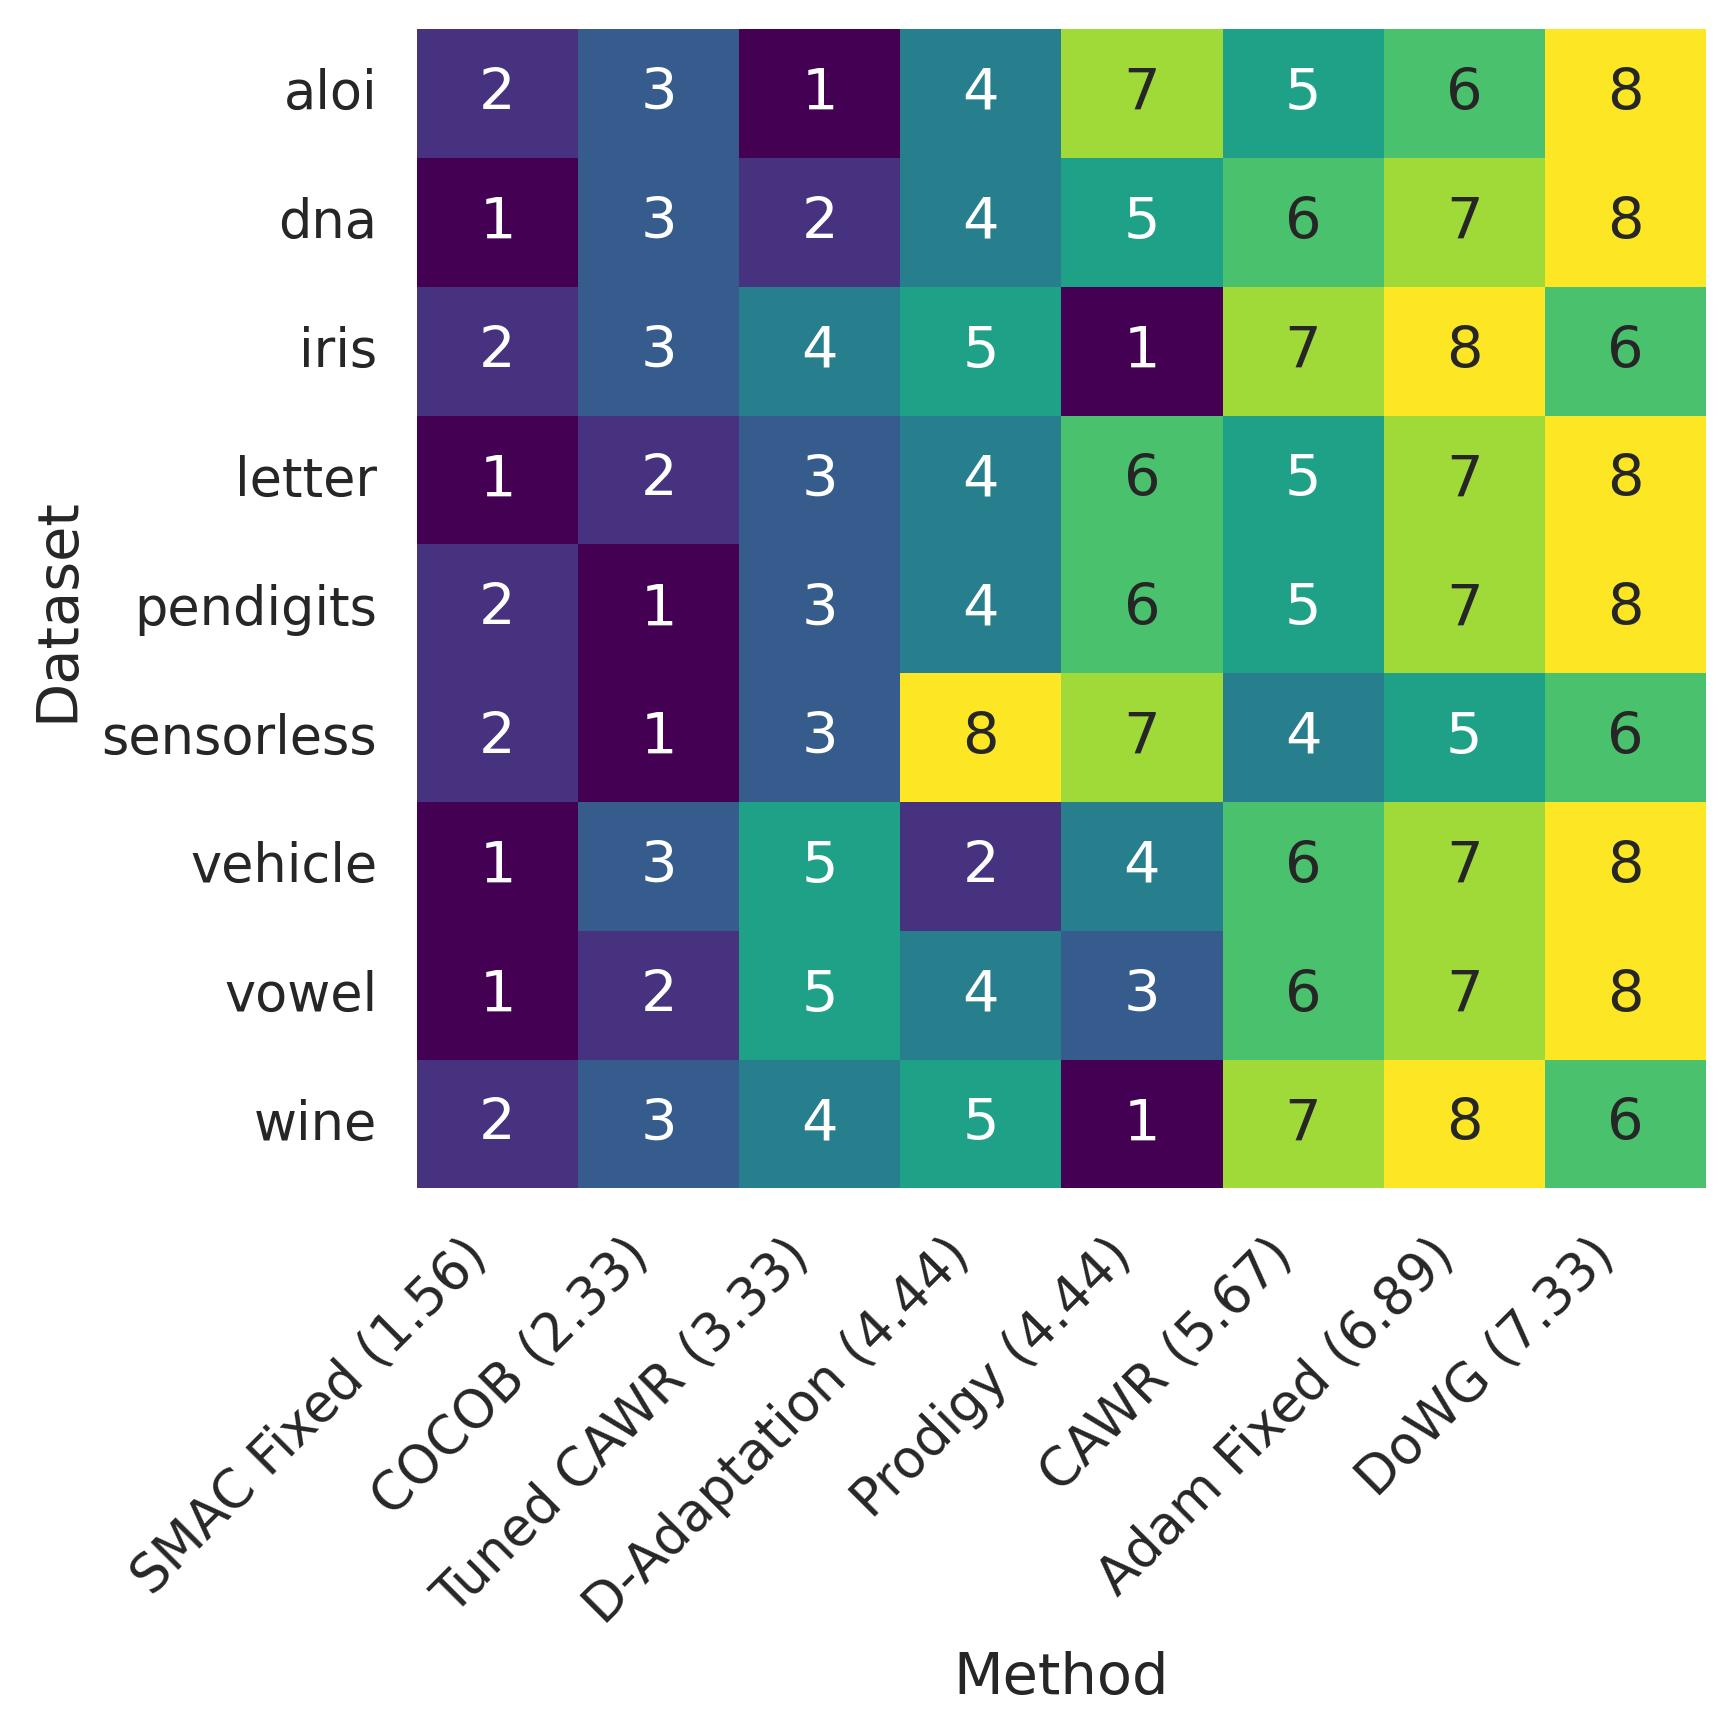

In [62]:
datasets_and_batches = {
    'aloi': 1688,
    'dna': 32,
    'iris': 3,
    'letter': 235,
    'pendigits': 118,
    'sensorless': 915,
    'vehicle': 14,
    'vowel': 9,
    'wine': 3
}

cawr_tl = pd.concat([toChunkedDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, datasets_and_batches[dataset], method='CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
tuned_cawr_tl = pd.concat([toChunkedDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, datasets_and_batches[dataset], method='Tuned CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
smacfixed_tl = pd.concat([toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='SMAC Fixed', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Adam Fixed', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
# cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

# 'seed', 'epoch', 'method', 'training_loss' 'dataset'
df_others = pd.concat([adam_fixed_tl, cawr_tl, smacfixed_tl, tuned_cawr_tl], ignore_index=True)

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
# adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Adam Fixed', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='DoWG', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
#

# 'seed', 'epoch', 'method', 'training_loss' 'dataset'

df_pfo = pd.concat([cocob_tl, dadaptation_tl, dowg_tl, prodigy_tl], ignore_index=True)

df_others["group"] = "others"
df_pfo["group"] = "parameterfree"

df = pd.concat([df_others, df_pfo], ignore_index=True)

# 1. Aggregate over seeds per epoch
df = df.groupby(["dataset", "method", "group", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method", "group"])["epoch"].idxmax()
].reset_index(drop=True)

# 3. Rank the methods for each dataset based on the final training loss (lower is better)
df["rank"] = df.groupby("dataset")["value"].rank(method="min", ascending=True)

# 4. Create a pivot table: datasets as rows and methods as columns (cells contain the rank)
pivot_df = df.pivot(index="dataset", columns="method", values="rank")

# 5. Compute the average rank for each method over all datasets
avg_ranks = df.groupby("method")["rank"].mean()

# 6. Sort the methods by average rank (lowest rank to highest rank)
sorted_methods = avg_ranks.sort_values().index.tolist()

# 7. Reorder the pivot table columns based on the sorted method order
pivot_df = pivot_df[sorted_methods]

# 8. Update the column labels to include the average rank
new_columns = [f"{method} ({avg_ranks[method]:.2f})" for method in pivot_df.columns]
pivot_df.columns = new_columns

# 9. Plot the heatmap with the sorted columns
plt.figure(figsize=(6, 6))
ax = sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="viridis", cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel("Method")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

# plot_performance_over_time(
#         data=df,
#         x="epoch",
#         y="rank",
#         xlabel="Epochs",
#         ylabel="Rank",
#         aggregation="rank",
#         errorbar="se",
#         hue="method",
#         col="dataset",
#         # row="dataset",
#         # col_wrap=3,
#         sharey=False,
#         aspect=1.5
#     )

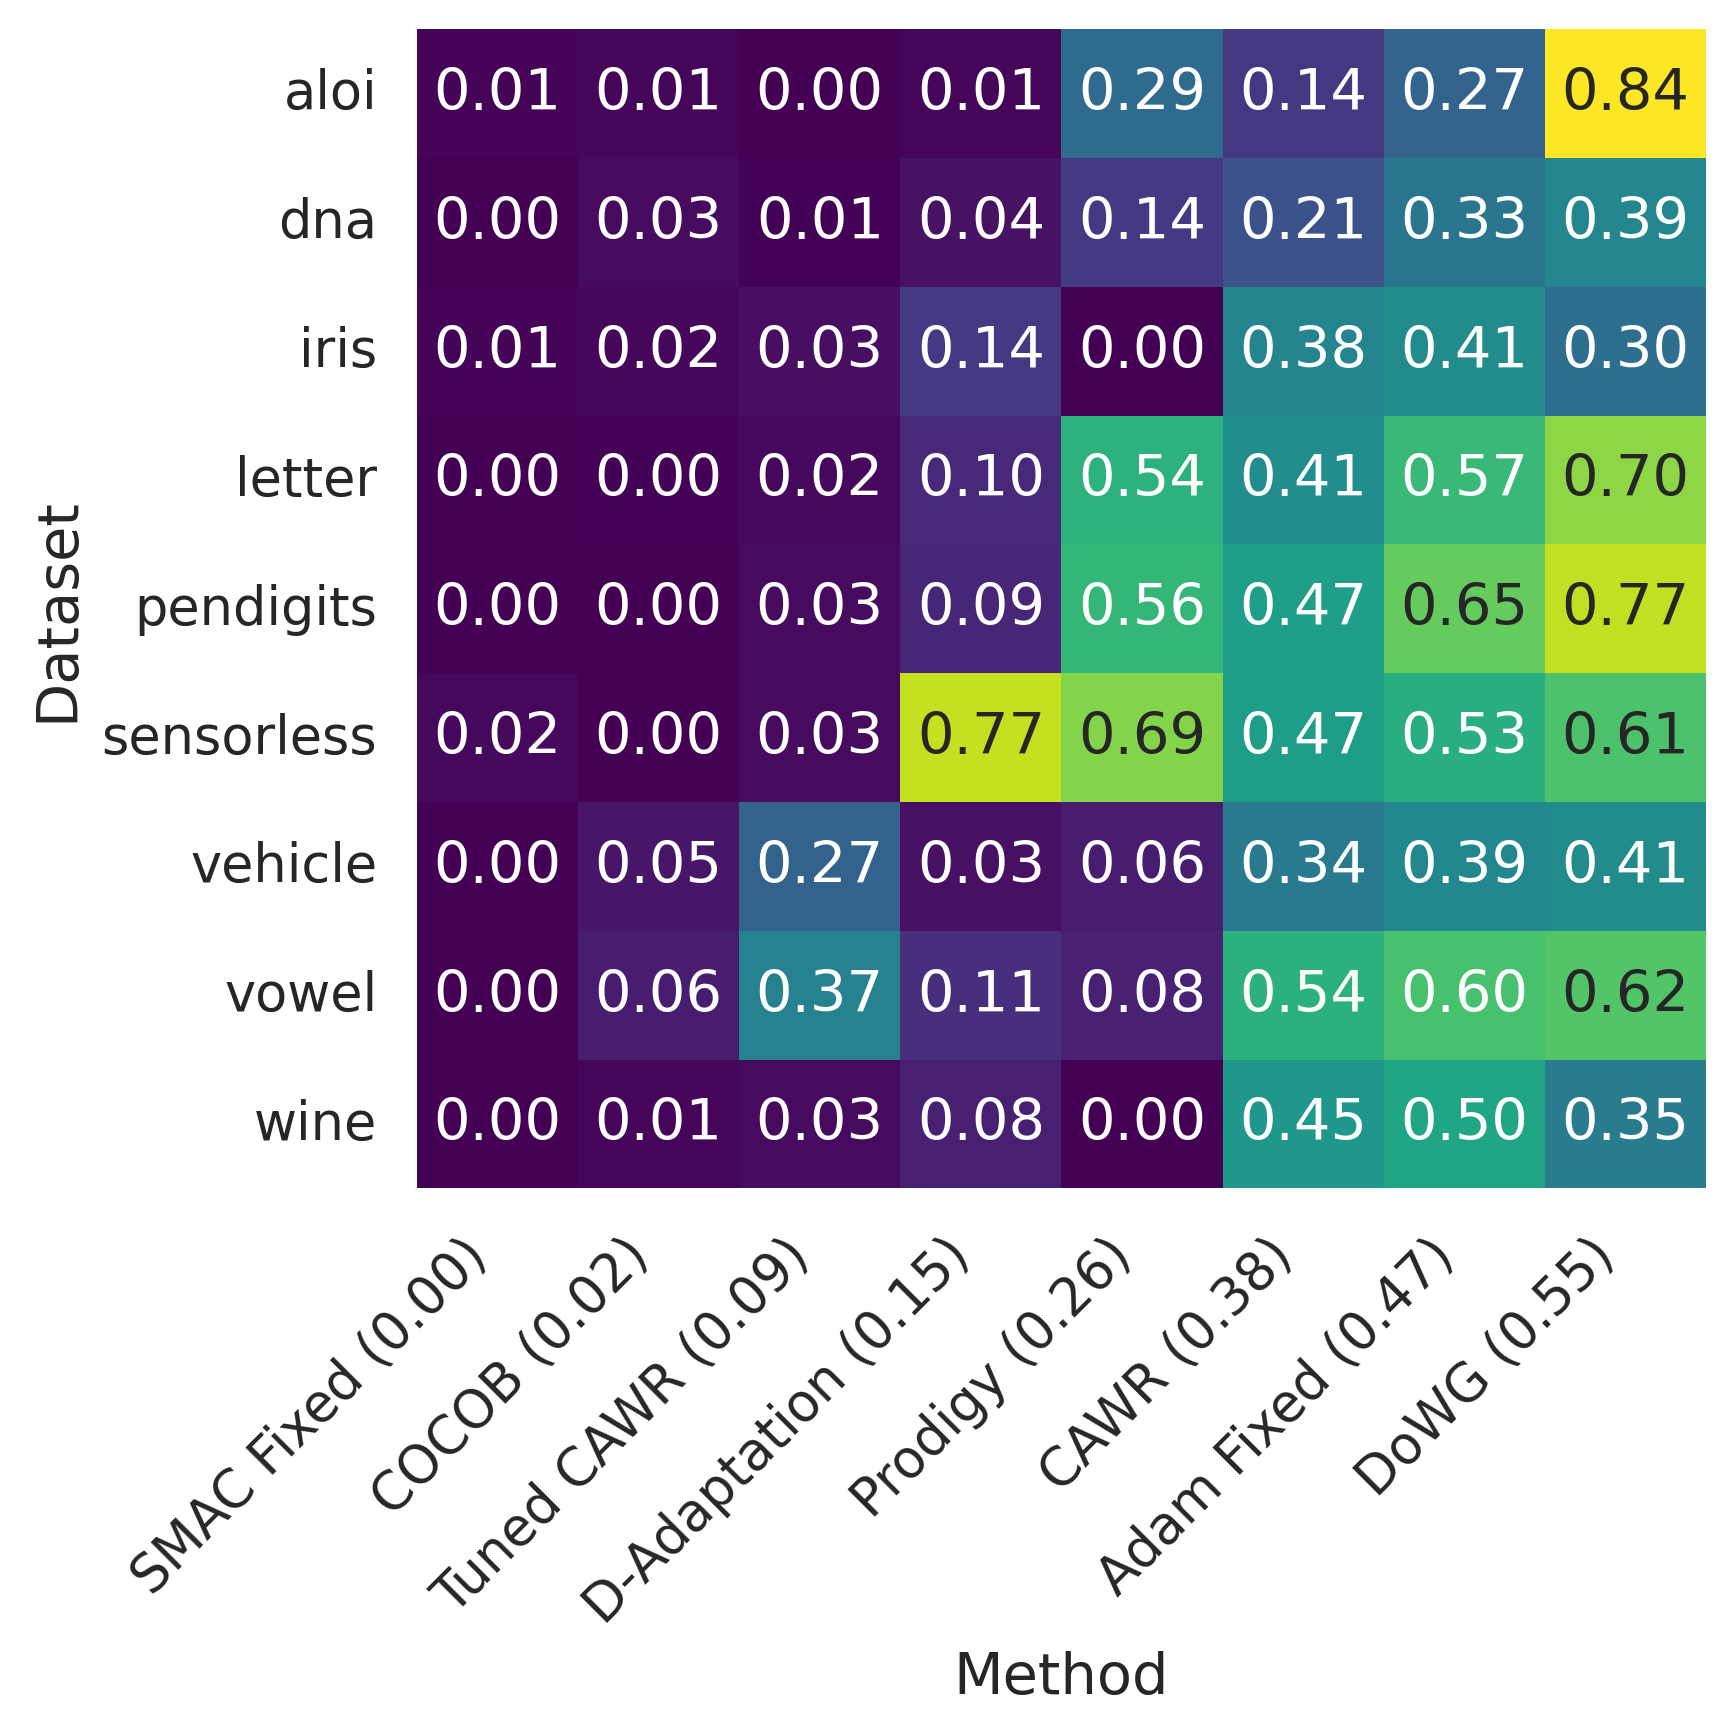

In [6]:
datasets_and_batches = {
    'aloi': 1688,
    'dna': 32,
    'iris': 3,
    'letter': 235,
    'pendigits': 118,
    'sensorless': 915,
    'vehicle': 14,
    'vowel': 9,
    'wine': 3
}

cawr_tl = pd.concat([
    toChunkedDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                         'training_losses', 3, datasets_and_batches[dataset],
                         method='CAWR', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

tuned_cawr_tl = pd.concat([
    toChunkedDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                         'training_losses', 3, datasets_and_batches[dataset],
                         method='Tuned CAWR', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

smacfixed_tl = pd.concat([
    toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'training_losses', 3, method='SMAC Fixed', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

adam_fixed_tl = pd.concat([
    toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'training_losses', 3, method='Adam Fixed', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

df_others = pd.concat([adam_fixed_tl, cawr_tl, smacfixed_tl, tuned_cawr_tl], ignore_index=True)

cocob_tl = pd.concat([
    toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'training_losses', 3, method='COCOB', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dadaptation_tl = pd.concat([
    toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'training_losses', 3, method='D-Adaptation', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

prodigy_tl = pd.concat([
    toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'training_losses', 3, method='Prodigy', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dowg_tl = pd.concat([
    toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'training_losses', 3, method='DoWG', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

df_pfo = pd.concat([cocob_tl, dadaptation_tl, dowg_tl, prodigy_tl], ignore_index=True)

df_others["group"] = "others"
df_pfo["group"] = "parameterfree"

df = pd.concat([df_others, df_pfo], ignore_index=True)

# 1. Aggregate over seeds per epoch
df = df.groupby(["dataset", "method", "group", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method", "group"])["epoch"].idxmax()
].reset_index(drop=True)

# 3. For each dataset, compute the best (lowest) training loss,
#    then compute the difference for each method.
df["best_value"] = df.groupby("dataset")["value"].transform("min")
df["diff"] = df["value"] - df["best_value"]

# 4. Create a pivot table: datasets as rows and methods as columns (cells contain the difference)
pivot_df = df.pivot(index="dataset", columns="method", values="diff")

# 5. Compute the average difference for each method over all datasets
avg_diffs = df.groupby("method")["diff"].mean()

# 6. Sort the methods by average difference (lowest difference first)
sorted_methods = avg_diffs.sort_values().index.tolist()

# 7. Reorder the pivot table columns based on the sorted method order
pivot_df = pivot_df[sorted_methods]

# 8. Update the column labels to include the average difference
new_columns = [f"{method} ({avg_diffs[method]:.2f})" for method in pivot_df.columns]
pivot_df.columns = new_columns

# 9. Plot the heatmap with the sorted columns; use the same layout and colors.
plt.figure(figsize=(6, 6))
ax = sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="viridis", cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel("Method")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

In [ ]:
# Group "others"
cawr_tl = pd.concat([
    toDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                         'validation_accuracies', 6, method='CAWR', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

tuned_cawr_tl = pd.concat([
    toDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                         'validation_accuracies', 6, method='Tuned CAWR', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

smacfixed_tl = pd.concat([
    toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='SMAC Fixed', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

adam_fixed_tl = pd.concat([
    toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='Adam Fixed', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

df_others = pd.concat([adam_fixed_tl, cawr_tl, smacfixed_tl, tuned_cawr_tl], ignore_index=True)

# Group "parameterfree"
cocob_tl = pd.concat([
    toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='COCOB', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dadaptation_tl = pd.concat([
    toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='D-Adaptation', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

prodigy_tl = pd.concat([
    toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='Prodigy', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dowg_tl = pd.concat([
    toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='DoWG', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

df_pfo = pd.concat([cocob_tl, dadaptation_tl, dowg_tl, prodigy_tl], ignore_index=True)

df_others["group"] = "others"
df_pfo["group"] = "parameterfree"

df = pd.concat([df_others, df_pfo], ignore_index=True)

print(df)

# 1. Aggregate over seeds per epoch
df = df.groupby(["dataset", "method", "group", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method", "group"])["epoch"].idxmax()
].reset_index(drop=True)

# 3. For each dataset, compute the best (highest) accuracy,
#    then compute the difference for each method as (best_value - current_value).
df["best_value"] = df.groupby("dataset")["value"].transform("max")
# df["diff"] = df["best_value"] - df["value"]
df["diff"] = (df["best_value"] - df["value"]) * 100

# 4. Create a pivot table: datasets as rows and methods as columns (cells contain the difference)
pivot_df = df.pivot(index="dataset", columns="method", values="diff")

# 5. Compute the average difference for each method over all datasets
avg_diffs = df.groupby("method")["diff"].mean()

# 6. Sort the methods by average difference (lowest difference first)
sorted_methods = avg_diffs.sort_values().index.tolist()

# 7. Reorder the pivot table columns based on the sorted method order
pivot_df = pivot_df[sorted_methods]

# 8. Update the column labels to include the average difference
new_columns = [f"{method} ({avg_diffs[method]:.1f})" for method in pivot_df.columns]
pivot_df.columns = new_columns
print(pivot_df)
# 9. Plot the heatmap with the sorted columns; maintain layout and colors
plt.figure(figsize=(6, 6))
ax = sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="viridis", cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel("Method")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

       epoch seed     value      method dataset          group
0          1    0  0.057600  Adam Fixed    aloi         others
1          2    0  0.115662  Adam Fixed    aloi         others
2          3    0  0.193602  Adam Fixed    aloi         others
3          4    0  0.269785  Adam Fixed    aloi         others
4          5    0  0.336446  Adam Fixed    aloi         others
...      ...  ...       ...         ...     ...            ...
71995     96    9  0.988125     Prodigy    wine  parameterfree
71996     97    9  0.968750     Prodigy    wine  parameterfree
71997     98    9  1.000000     Prodigy    wine  parameterfree
71998     99    9  0.988125     Prodigy    wine  parameterfree
71999    100    9  0.994792     Prodigy    wine  parameterfree

[72000 rows x 6 columns]
            SMAC Fixed (5.5)  Tuned CAWR (7.6)  COCOB (9.2)  CAWR (12.5)  \
dataset                                                                    
aloi               12.846377         16.613226    41.394216     3.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations

# --- Data loading steps (unchanged, except we now use "validation_accuracies", 6) ---

datasets_and_batches = {
    'aloi': 1688,
    'dna': 32,
    'iris': 3,
    'letter': 235,
    'pendigits': 118,
    'sensorless': 915,
    'vehicle': 14,
    'vowel': 9,
    'wine': 3
}

# Group "others"
cawr_tl = pd.concat([
    toDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                         'validation_accuracies', 6, method='CAWR', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

tuned_cawr_tl = pd.concat([
    toDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                         'validation_accuracies', 6, method='Tuned CAWR', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

smacfixed_tl = pd.concat([
    toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='SMAC Fixed', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

adam_fixed_tl = pd.concat([
    toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='Adam Fixed', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

df_others = pd.concat([adam_fixed_tl, cawr_tl, smacfixed_tl, tuned_cawr_tl], ignore_index=True)

# Group "parameterfree"
cocob_tl = pd.concat([
    toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='COCOB', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dadaptation_tl = pd.concat([
    toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='D-Adaptation', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

prodigy_tl = pd.concat([
    toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='Prodigy', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dowg_tl = pd.concat([
    toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'validation_accuracies', 6, method='DoWG', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

df_pfo = pd.concat([cocob_tl, dadaptation_tl, dowg_tl, prodigy_tl], ignore_index=True)

df_others["group"] = "others"
df_pfo["group"] = "parameterfree"

df = pd.concat([df_others, df_pfo], ignore_index=True)
df['value'] = df.groupby(['method', 'dataset', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
df['value'] = df['value'] * 100
# 1. Aggregate over seeds per epoch
df = df.groupby(["dataset", "method", "group", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method", "group"])["epoch"].idxmax()
].reset_index(drop=True)

# At this point, for each dataset-method we have the final validation accuracy in df["value"].
# Higher accuracy is better.

# --- Compute Marginal Contribution via Shapley Values ---

def calculate_marginal_contributions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate marginal contribution per method for each dataset.

    Args:
    df (pd.DataFrame): The input DataFrame containing columns:
                       ['dataset', 'method', 'group', 'epoch', 'value']

    Returns:
    pd.DataFrame: A DataFrame showing marginal contributions for each method per dataset.
    """
    results = []

    # Get unique datasets and methods
    datasets = df['dataset'].unique()
    methods = df['method'].unique()
    
    for dataset in datasets:
        # Filter the DataFrame for the current dataset
        df_dataset = df[df['dataset'] == dataset]

        # Calculate the performance with all methods (Baseline)
        baseline_performance = df_dataset['value'].mean()

        for method in methods:
            # Filter out the current method to calculate "without" performance
            df_without_method = df_dataset[df_dataset['method'] != method]

            # Calculate the best performance without the current method
            if not df_without_method.empty:
                performance_without = df_without_method['value'].mean()
            else:
                performance_without = 0  # If no methods are left

            # Calculate the marginal contribution
            marginal_contribution = baseline_performance - performance_without

            # Store the results
            results.append({
                'dataset': dataset,
                'method': method,
                'baseline_performance': baseline_performance,
                'performance_without': performance_without,
                'marginal_contribution': marginal_contribution
            })

    # Convert the results to a DataFrame
    result_df = pd.DataFrame(results)
    
    return result_df

mcs = calculate_marginal_contributions(df)
mcs = mcs.groupby(["method"], as_index=False)["marginal_contribution"].mean()
print(mcs)

         method  marginal_contribution
0    Adam Fixed              -0.390860
1          CAWR               0.955963
2         COCOB               1.408628
3  D-Adaptation              -0.399944
4          DoWG              -3.884135
5       Prodigy              -1.314404
6    SMAC Fixed               1.969940
7    Tuned CAWR               1.654811


In [17]:
dadaptation_dlrs = pd.concat([
    toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'dlrs', 10, method='D-Adaptation', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

dadaptation_dlrs = dadaptation_dlrs.groupby(["dataset", "method", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
dadaptation_dlrs = dadaptation_dlrs.loc[
    dadaptation_dlrs.groupby(["dataset", "method"])["epoch"].idxmax()
].reset_index(drop=True)

print(dadaptation_dlrs)

      dataset        method  epoch      value
0        aloi  D-Adaptation    100   1.723248
1         dna  D-Adaptation    100   3.833744
2        iris  D-Adaptation    100   5.480978
3      letter  D-Adaptation    100   3.077252
4   pendigits  D-Adaptation    100   4.015375
5  sensorless  D-Adaptation    100  34.429954
6     vehicle  D-Adaptation    100   2.133280
7       vowel  D-Adaptation    100   2.596068
8        wine  D-Adaptation    100   4.830912


In [19]:
prodigy_dlrs = pd.concat([
    toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl',
                'dlrs', 10, method='Prodigy', dataset=dataset)
    for dataset in datasets_and_batches.keys()
], ignore_index=True)

prodigy_dlrs = prodigy_dlrs.groupby(["dataset", "method", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
prodigy_dlrs = prodigy_dlrs.loc[
    prodigy_dlrs.groupby(["dataset", "method"])["epoch"].idxmax()
].reset_index(drop=True)

print(prodigy_dlrs)

      dataset   method  epoch      value
0        aloi  Prodigy    100   3.322423
1         dna  Prodigy    100   4.150663
2        iris  Prodigy    100   7.709441
3      letter  Prodigy    100   7.305961
4   pendigits  Prodigy    100  11.007152
5  sensorless  Prodigy    100  10.401120
6     vehicle  Prodigy    100   5.746655
7       vowel  Prodigy    100   6.049577
8        wine  Prodigy    100   9.061060
